In [1]:
import numpy as np
#from numpy import linalg as LA
from scipy import linalg as LA


import cvxpy
import optim_tools #own file with helper

import control as pc
import matplotlib.pyplot as plt
import itertools

from sysident import loadtools
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
print cvxpy.installed_solvers()
print cvxpy.__version__

['CVXOPT', 'MOSEK', 'ECOS_BB', 'SUPER_SCS', 'GLPK_MI', 'SCS', 'ECOS', 'GLPK', 'OSQP']
1.0.10


In [3]:
def add_position_state(A0, B0, C0):
    A = np.vstack((C0, A0))
    A = np.hstack((np.zeros((A.shape[0],1)), A))
    
    B = np.vstack((np.zeros((1, B0.shape[1])), B0))
    
    C = np.matrix(np.zeros(B.shape).T)
    C[0,0] = 1
    return A, B, C

#add_position_state(A, B, C)

#def load_with_delay(fname):
#    A, B, C, D = loadtools.getModel(fname)
#    return A, B, C, D
#
#def load_without_delay(fname):
#    res, _ = loadtools.loadNPY(fname)
#    return res['A'], res['B'], res['C'], res['D'], res['delay']

def getX00(x0):
    arrays = []
    X00 = []
    for x in x0:
        arrays.append((x, -x))
    for per in list(itertools.product(*arrays)):
        X00.append(np.matrix(per).T)
    return X00
    
#getX00([1.0, 0.5, 0.025])

In [4]:
folder = "/home/lth/jupyter_nb/optimization/models/"

fnames = [folder+"ss_20190206-114257_poles2_manual_ident_huber_no_delay_0.0330611300999.npy",
          folder+"ss_20190206-114257_poles3_manual_ident_huber_pade1_0.0330611300999.npy",
          folder+"ss_20190206-114257_poles5_manual_ident_huber_pade3_0.0330611300999.npy"]

_A0x, _B0x, _C0x, D0, delay = loadtools.getDelayModel(fnames[0])
A0, B0, C0 = add_position_state(_A0x, _B0x, _C0x)

_A1x, _B1x, _C1x, D1 = loadtools.getModel(fnames[1])
A1, B1, C1 = add_position_state(_A1x, _B1x, _C1x)
ss1 = pc.ss(A1, B1, C1, D1) * pc.tf(*pc.pade(delay, 1))

ss2 = pc.series(pc.tf(*pc.pade(delay, 2)), pc.ss(A0, B0, C0, D0))

_A3x, _B3x, _C3x, D3 = loadtools.getModel(fnames[2])
A3, B3, C3 = add_position_state(_A3x, _B3x, _C3x)

#A, B, C, D = A0, B0, C0, D0                  # Entwurf auf PT2 (ohne delay)
A, B, C, D = A1, B1, C1, D1                  # Entwurf auf pade1*PT2
#A, B, C, D = ss1.A, ss1.B, ss1.C, ss1.D      # Entwurf auf pade1*PT2*pade1
#A, B, C, D = ss2.A, ss2.B, ss2.C, ss2.D      # Entwurf auf pade2*PT2
#A, B, C, D = A3, B3, C3, D3                  # Entwurf auf pade3*PT2

u_max = 2.0
U_max = [u_max]

xx0 = [1.0, 2.0, 10.0,  100.0, 1000., 10000.]
print 'Limits:', xx0[0:len(B)]

X00 = getX00(xx0[0:len(B)])

# Transform into reachable form to specify boundaries useful
(A1, B1, C1, D1), T1, Q1 = optim_tools.get_Steuerungsnormalform(A, B, C.T, D)
X0 = [T1.dot(x0) for x0 in X00]
#print X0

Limits: [1.0, 2.0, 10.0, 100.0]


In [5]:
## Helper functions for optimization problem

def Tri(i, n_u):
    if n_u>1:
        print "not implemented"
        print "alle permutationen mit einsen auf der hauptdiagonalen!"
        raise Error()
        
    if i==1:
        return np.eye(n_u)
    else:
        # only true for n_u == 1
        return np.zeros((n_u, n_u))

def negTri(i, n_u):
    return np.eye(n_u) - Tri(i, n_u)


In [6]:
#%%time
# Satz 6.6

# Init
n = B.shape[0] # get dim of system
n_u = B.shape[1] 

# Variables
X = cvxpy.Variable((n, n), PSD=True)
Y = cvxpy.Variable((n, n), PSD=True)
W = cvxpy.Variable((n_u, n_u), PSD=True)

Ak_h = cvxpy.Variable(A.shape, PSD=True)
Bk_h = cvxpy.Variable(B.shape)
Ck_h = cvxpy.Variable(C.shape)
Dk_h = cvxpy.Variable(D.shape)

Ch = cvxpy.Variable(C.shape)
Dh = cvxpy.Variable(D.shape)

# Substitutionen
C_hat = lambda i: Tri(i, n_u)*Ck_h + negTri(i, n_u)*Ch
D_hat = lambda i: Tri(i, n_u)*Dk_h + negTri(i, n_u)*Dh

Xi = cvxpy.bmat([[ A*X + B*Ck_h, A + B*Dk_h*C ],
                 [ Ak_h,         Y*A + Bk_h*C ]])

I = np.eye(n)

# Bisection parameter
g = cvxpy.Parameter(nonneg=True)

# Pole restriction
ro = cvxpy.Parameter(nonneg=True) # Real <=-ro
ni = cvxpy.Parameter(nonneg=True) # |Imag| <= ni*Real

#####################################################
ro.value = 100
#ro.value = 80
ni.value = 1
#####################################################
poles = pc.pole(pc.ss(A, B, C, D))
if any(poles.real < -ro.value) or any(poles.imag < ni.value*poles.real):
    print "WARNING: Pole restriction too tight for model?"
    print poles
    
    raw_input("Press Enter to continue...")


# Define Constraints

# (6.39a)
const_639a = cvxpy.bmat([[X, I],
                         [I, Y]]) >> 0
                         #[I, Y]]) == cvxpy.Variable((2*n, 2*n), PSD=True)



# (6.39b)
const_639b = cvxpy.bmat([[ X*A.T + A*X + B*Ck_h + (B*Ck_h).T, Ak_h.T + A + B*Dk_h*C            ],
                         #[ cvxpy.Variable((n, n), PSD=False),          A.T*Y + Y*A + Bk_h*C + (Bk_h*C).T]]) + \
                         [ (Ak_h.T + A + B*Dk_h*C).T,         A.T*Y + Y*A + Bk_h*C + (Bk_h*C).T]]) + \
             2*g*cvxpy.bmat([[X, I],
                             [I, Y]]) << 0
                             #[I, Y]]) == -cvxpy.Variable((2*n, 2*n), PSD=True)
    
# (6.39c)
const_639c = [cvxpy.bmat([[ X*A.T + A*X + B*C_hat(i) + (B*C_hat(i)).T, Ak_h.T + A + B*D_hat(i)*C            ],
                          [ (Ak_h.T + A + B*D_hat(i)*C).T,             A.T*Y + Y*A + Bk_h*C + (Bk_h*C).T]]) << 0 for i in range(2, (2**n_u)+1)]
                          #[ cvxpy.Variable((n, n), PSD=False),                      A.T*Y + Y*A + Bk_h*C + (Bk_h*C).T]]) == -cvxpy.Variable((2*n, 2*n), PSD=True) for i in range(2, (2**n_u)+1)]

    
# (6.39d)
const_639d = cvxpy.bmat([[ X,  I,    Ch.T     ],
                         [ I,  Y,    (Dh*C).T ],
                         [ Ch, Dh*C, W        ]]) >> 0
                         #[ Ch, Dh*C, W        ]]) == cvxpy.Variable((2*n+n_u, 2*n+n_u), PSD=True)

const_639e = [W[j,j] <= U_max[j]**2 for j in range(0, n_u)]

const_639f = [ X0[k].T*Y*X0[k] <= 1.0
                            for k in range(0, len(X0))]

const_621a = Xi.T + Xi + ro*cvxpy.bmat([[X, I],
                                        [I, Y]]) >> 0
                                        #[I, Y]]) == cvxpy.Variable((2*n, 2*n), PSD=True)

const_621b = cvxpy.bmat([[ ni*(Xi.T + Xi), Xi.T - Xi ],
                         [ -Xi.T + Xi,     ni*(Xi.T + Xi) ]]) << 0
                         #[ -Xi.T + Xi,     ni*(Xi.T + Xi) ]]) == -cvxpy.Variable((4*n, 4*n), PSD=True)

    
# Collect all constraints
constraints_639 = []
constraints_639.append(const_639a)
constraints_639.append(const_639b)
constraints_639.extend(const_639c)
constraints_639.append(const_639d)
constraints_639.extend(const_639e)
constraints_639.extend(const_639f)

constraints_639.append(const_621a)
constraints_639.append(const_621b)


# Form problem.
prob_66 = cvxpy.Problem(cvxpy.Minimize(0), constraints_639)

# bisection with one solver
#[[X_o, Y_o, W_o,
#  Ak_h_o, Bk_h_o, Ck_h_o, Dk_h_o,
#  Ch_o, Dh_o], g_o] = optim_tools.bisect_max(0, None, prob_66, g, [X, Y, W, Ak_h, Bk_h, Ck_h, Dk_h, Ch, Dh], bisect_verbose=True,
#                                                      bisection_tol=0.01,
#                                                      #solver=cvxpy.CVXOPT, verbose=False,  max_iters=50000)
#                                                      solver=cvxpy.MOSEK, verbose=False)
#                                                      #solver=cvxpy.SCS, max_iters=50000)

# bisection alternative with list of multiple solvers
[[X_o, Y_o, W_o,
  Ak_h_o, Bk_h_o, Ck_h_o, Dk_h_o,
  Ch_o, Dh_o], g_o] = optim_tools.bisect_max2(0, None, prob_66, g, [X, Y, W, Ak_h, Bk_h, Ck_h, Dk_h, Ch, Dh],
                                                      bisect_verbose=True,
                                                      bisection_tol=0.5,
                                                      solvers=[
                                                               (cvxpy.CVXOPT, {'verbose':False}),
                                                               (cvxpy.MOSEK, {'verbose':False}),
                                                               #(cvxpy.SCS, {'max_iters':5000, 'warm_start':True, 'verbose':True}),
                                                               #(cvxpy.SUPER_SCS, {'max_iters':50000, 'verbose':True}),
                                                              ])
print "g:", g_o

print
print '-----------------------'

processing upper bound: 1.0
processing upper bound: 2.0
processing upper bound: 4.0
processing upper bound: 8.0
processing upper bound: 16.0
processing upper bound: 32.0
found bounds: [16.0-32.0]
Range: 16.0-32.0; parameter 24.0 -> infeasible
Range: 16.0-24.0; parameter 20.0 -> optimal
Range: 20.0-24.0; parameter 22.0 -> infeasible
Range: 20.0-22.0; parameter 21.0 -> optimal
Range: 21.0-22.0; parameter 21.5 -> optimal
Range: 21.5-22.0; parameter 21.75 -> optimal
g: 21.75

-----------------------


In [7]:
# QR Decomposition for M and N
M, NT = LA.qr(I - X_o.dot(Y_o))
N = NT.T
#assert(np.allclose(I - X_o.dot(Y_o), M.dot(N.T)))

# LU Decomposition for M and N
#M, L, U = LA.lu(I - X_o.dot(Y_o))
#N = L.dot(U).T

# Reconstruction
Ek = -LA.solve(N, Y_o.dot(B))
Dk = np.matrix(Dk_h_o)

Ck = LA.solve(M, (Ck_h_o - Dk.dot(C).dot(X_o)).T).T
#Ck_1 = (Ck_h_o - Dk.dot(C).dot(X_o)).dot(LA.inv(M).T) #Check
#assert(np.allclose(Ck_1, Ck))

Bk = LA.solve(N, Bk_h_o)

temp_alpha = LA.solve(N, (Ak_h_o-Y_o.dot(A).dot(X_o)))
temp_beta = Bk.dot(C).dot(X_o)
Ak = (LA.solve(M, temp_alpha.T) - LA.solve(M, temp_beta.T)).T

#Ak_1 = LA.solve(N, (Ak_h_o-Y_o.dot(A).dot(X_o))).dot(LA.inv(M).T) - Bk.dot(C).dot(X_o).dot(LA.inv(M).T) #Check
#assert(np.allclose(Ak_1, Ak))


In [8]:
print Ak
print Bk
print Ck
print Dk
print Ek
print u_max
#print dT
print
print A
print B
print C
print D

[[-5.51889817e+01 -1.40446516e+00 -1.84840238e-01 -1.11484633e-03]
 [-5.21939511e+03 -2.41630400e+02 -2.96141678e+01 -3.29243276e-01]
 [ 4.77141059e+04  1.83209884e+03  2.23125868e+02  2.51777654e+00]
 [-3.10989532e+05 -1.18612343e+04 -1.91092333e+03 -6.61136085e+01]]
[[-3.80933687e-03]
 [-5.63409585e-01]
 [ 5.34342151e+00]
 [-3.50510545e+01]]
[[-3.59419473e+05 -1.34282562e+04 -1.79374788e+03  3.14749830e+00]]
[[-40.64853585]]
[[ 2.85569560e-04]
 [-3.24276703e-02]
 [ 1.90870806e-01]
 [-1.07601051e+00]]
2.0

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e+00]
 [ 0.00000000e+00  7.10542736e-15 -7.66708106e-15  6.69292402e+00]
 [ 0.00000000e+00  1.00000000e+02  2.00673740e-14  5.62730971e+01]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+02 -1.35227553e+02]]
[[  0.        ]
 [  6.7209252 ]
 [-11.11006912]
 [  0.        ]]
[[1. 0. 0. 0.]]
[[0.]]


In [9]:
from numpy.linalg import solve, inv

def control_func(y, s, x, k, A, b, c):
    N = -c.dot(solve(A-b.dot(k.T), b))
    u = solve(N, np.array([s]))-k.T.dot(x)
    return u

class control_func_dyn_out():
    def __init__(self, Ak, Bk, Ck, Dk, Ek, A, B, C, D, umax=None, dT=1e-3):
        self.Ak = Ak
        self.Bk = Bk
        self.Ck = Ck
        self.Dk = Dk
        self.Ek = Ek
        self.umax = umax
        self.dT = dT

        self.z = np.zeros(B.shape)
                
        # Construct Prefilter
        C2 = np.hstack((-C, np.zeros(Ck.shape)))

        A2_u = np.hstack(((A+B.dot(Dk).dot(C)), B.dot(Ck)))
        A2_d = np.hstack((Bk.dot(C), Ak))

        A2 = np.vstack((A2_u, A2_d))
        B2 = np.vstack((B, np.zeros(Bk.shape)))

        self.N = inv(C2.dot(inv(A2)).dot(B2))
        #print self.N
        
    def estimate(self, y, u):
        # already saturated in this case
        #if self.umax is not None:
        #    u = optim_tools.sat(u, self.umax)
        
        z_dot = self.Ak.dot(self.z) + self.Bk.dot(y) + self.Ek.dot(u)
        return self.z + z_dot*self.dT
        
    def regulate(self, y, s, x):
        u = self.N.dot(s)+self.Ck.dot(self.z) + self.Dk.dot(y)

        # Saturate 
        if self.umax is not None:
            u = optim_tools.sat(u, self.umax)
            
        self.z = self.estimate(y, u)
        return u

In [10]:
# Timeline
T = np.arange(0, 2, 1e-3) 

#s: input, e.g., step function with amplitude of 0.2
#s = np.zeros(len(T));
s = np.ones(len(T))*1;


# Initial state
x0 = 0

In [11]:

y2a, u2a, u2a_sat = optim_tools.simulate(A0, B0, C0, D0, 
                                   control_func_dyn_out(Ak, Bk, Ck, Dk, Ek,
                                                        A, B, C, D,
                                                        umax=u_max).regulate,
                                   s, T, delay_u=0, delay_y=None, umax=u_max, x0=x0)


Setting initial value vector to [[0 0 0]]


In [12]:

y2b, u2b, u2b_sat = optim_tools.simulate(A0, B0, C0, D0, 
                                   control_func_dyn_out(Ak, Bk, Ck, Dk, Ek,
                                                        A, B, C, D,
                                                        umax=u_max).regulate,
                                   s, T, delay_u=0.01, delay_y=None, umax=u_max, x0=x0)


Setting initial value vector to [[0 0 0]]


In [13]:

y2c, u2c, u2c_sat = optim_tools.simulate(A0, B0, C0, D0, 
                                   control_func_dyn_out(Ak, Bk, Ck, Dk, Ek,
                                                        A, B, C, D,
                                                        umax=u_max).regulate,
                                   s, T, delay_u=delay, delay_y=None, umax=u_max, x0=x0)


Setting initial value vector to [[0 0 0]]


In [14]:

y2d, u2d, u2d_sat = optim_tools.simulate(A0, B0, C0, D0, 
                                   control_func_dyn_out(Ak, Bk, Ck, Dk, Ek,
                                                        A, B, C, D,
                                                        umax=u_max).regulate,
                                   s, T, delay_u=2*delay, delay_y=None, umax=u_max, x0=x0)


Setting initial value vector to [[0 0 0]]


In [15]:

y2e, u2e, u2e_sat = optim_tools.simulate(A0, B0, C0, D0, 
                                   control_func_dyn_out(Ak, Bk, Ck, Dk, Ek,
                                                        A, B, C, D,
                                                        umax=u_max).regulate,
                                   s, T, delay_u=4*delay, delay_y=None, umax=u_max, x0=x0)


Setting initial value vector to [[0 0 0]]


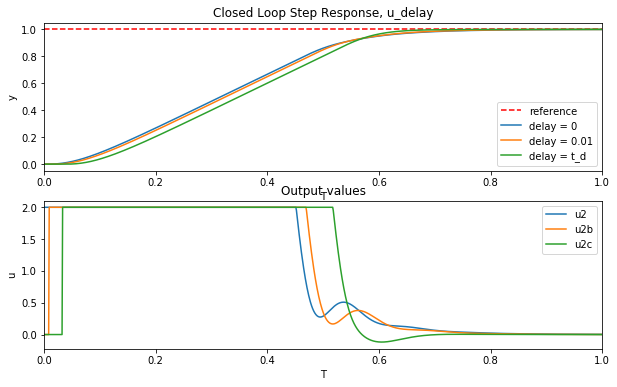

In [16]:
pylab.rcParams['figure.figsize'] = (10, 6)

ax1 = plt.subplot(2, 1, 1)
ax1.plot(T[:], s, 'r--', label='reference')
#line0, = plt.plot(T[:], np.array(y1[0,:].T), 'r', label='dyn_out')
line1, = plt.plot(T[:], np.array(y2a[0,:].T), '-', label='delay = 0')
line1, = plt.plot(T[:], np.array(y2b[0,:].T), '-', label='delay = 0.01')
line1, = plt.plot(T[:], np.array(y2c[0,:].T), '-', label='delay = t_d')
#line1, = plt.plot(T[:], np.array(y2d[0,:].T), '-', label='delay = 2*t_d')
#line1, = plt.plot(T[:], np.array(y2e[0,:].T), '-', label='delay = 4*t_d')
#line1, = plt.plot(T[:], np.array(y3[0,:].T), 'g', label='dyn_out.delay pade3')


#first_legend = plt.legend(handles=[line1], loc=1)
ax1.legend()
plt.xlabel('T')
plt.ylabel('y')
plt.title('Closed Loop Step Response, u_delay')


ax2 = plt.subplot(2, 1, 2)

#line0, = plt.plot(T, u1, 'r--', label='u1')
ax2.plot(T, u2a_sat, '-', label='u2')
ax2.plot(T, u2b_sat, '-', label='u2b')
ax2.plot(T, u2c_sat, '-', label='u2c')
#ax2.plot(T, u2d_sat, '-', label='u2d')
#ax2.plot(T, u2e_sat, '-', label='u2e')
#line2, = plt.plot(T, u2b_sat, 'b--', label='u2b')
#line2, = plt.plot(T, u3, 'g', label='u3')

ax1.set_xlim([0, 1])
ax2.set_xlim([0, 1])

#>first_legend = plt.legend(handles=[line1, line2, line1b, line2b], loc=1)
plt.legend()
plt.xlabel('T')
plt.ylabel('u')
plt.title('Output values')
plt.show()

#loadtools.saveNPY(fname, plot_control_step_y=(T[:], np.array(y1[0,:].T)),
#                         plot_control_step_u=(T, u1),
#                         plot_control_step_delay_y=(T[:], np.array(y2[0,:].T)),
#                         plot_control_step_delay_u=(T, u2),
#                         plot_control_step_s=(T[:], s))

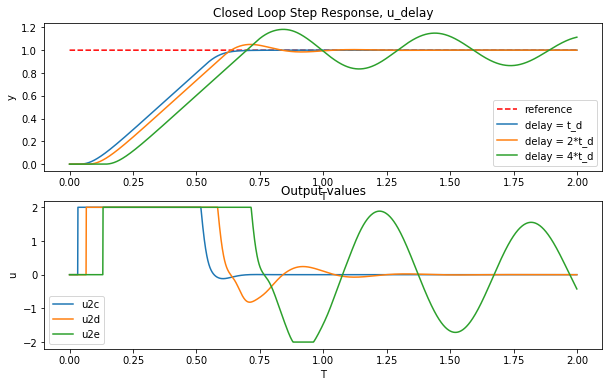

In [17]:
pylab.rcParams['figure.figsize'] = (10, 6)

ax1 = plt.subplot(2, 1, 1)
ax1.plot(T[:], s, 'r--', label='reference')
#line0, = plt.plot(T[:], np.array(y1[0,:].T), 'r', label='dyn_out')
#line1, = plt.plot(T[:], np.array(y2a[0,:].T), '-', label='delay = 0')
#line1, = plt.plot(T[:], np.array(y2b[0,:].T), '-', label='delay = 0.01')
line1, = plt.plot(T[:], np.array(y2c[0,:].T), '-', label='delay = t_d')
line1, = plt.plot(T[:], np.array(y2d[0,:].T), '-', label='delay = 2*t_d')
line1, = plt.plot(T[:], np.array(y2e[0,:].T), '-', label='delay = 4*t_d')
#line1, = plt.plot(T[:], np.array(y3[0,:].T), 'g', label='dyn_out.delay pade3')


#first_legend = plt.legend(handles=[line1], loc=1)
ax1.legend()
plt.xlabel('T')
plt.ylabel('y')
plt.title('Closed Loop Step Response, u_delay')


ax2 = plt.subplot(2, 1, 2)

#line0, = plt.plot(T, u1, 'r--', label='u1')
#ax2.plot(T, u2a_sat, '-', label='u2')
#ax2.plot(T, u2b_sat, '-', label='u2b')
ax2.plot(T, u2c_sat, '-', label='u2c')
ax2.plot(T, u2d_sat, '-', label='u2d')
ax2.plot(T, u2e_sat, '-', label='u2e')
#line2, = plt.plot(T, u2b_sat, 'b--', label='u2b')
#line2, = plt.plot(T, u3, 'g', label='u3')



#>first_legend = plt.legend(handles=[line1, line2, line1b, line2b], loc=1)
plt.legend()
plt.xlabel('T')
plt.ylabel('u')
plt.title('Output values')
plt.show()

#loadtools.saveNPY(fname, plot_control_step_y=(T[:], np.array(y1[0,:].T)),
#                         plot_control_step_u=(T, u1),
#                         plot_control_step_delay_y=(T[:], np.array(y2[0,:].T)),
#                         plot_control_step_delay_u=(T, u2),
#                         plot_control_step_s=(T[:], s))

In [18]:
print ro.value
print ni.value

100
1
